# Improving a Logistic Regression Model for Diabetes Prediction
# Author: Anthony Okeibuno
# Date: 20-12-2025

## 1. Introduction

In a previous project, I built a baseline Logistic Regression model to predict diabetes using clinical features.
While the model achieved reasonable performance, machine learning models are rarely improved by changing algorithms alone.

This project focuses on improving the same Logistic Regression model by:
- Cleaning biologically implausible values
- Scaling features appropriately
- Addressing class imbalance
- Applying regularization thoughtfully

The goal is not just higher accuracy, but a deeper understanding of *why* these improvements work.

## 2. Importing Libraries

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# For plot style
sns.set(style="whitegrid")

## 3. Loading the Dataset

In [45]:
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 4. Baseline Model Recap (Control Experiment)
We'll recreate a simple baseline Logistic Regression model as a control experiment, so that we can measure whether later changes actually improve performance.

In [46]:
X = df.drop("Outcome", axis=1)  # All columns except the outcome variable
y = df["Outcome"]                # Target variable to predict

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize logistic regression model as baseline
# max_iter=1000 allows more iterations for convergence
baseline_model = LogisticRegression(max_iter=1000)

# Train the model on the training data
baseline_model.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = baseline_model.predict(X_test)              # Predicted class labels (0 or 1)
y_proba = baseline_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for positive class

# Evaluate model performance using accuracy and ROC AUC score
baseline_acc = accuracy_score(y_test, y_pred) 
baseline_auc = roc_auc_score(y_test, y_proba)

print(f"baseline_acc: {baseline_acc} \nbaseline_auc: {baseline_auc}")

baseline_acc: 0.7467532467532467 
baseline_auc: 0.8128558310376492


The baseline model achieves approximately 75% accuracy and a ROC AUC of 0.81. While this indicates that logistic regression might capture meaningful patterns in the data, the model does not account for feature scaling, data quality issues, or class imbalance. So, these results would serve as a reference point for evaluating subsequent improvements and predictions.

## 5. Handling Biologically Implausible Zero Values

Some features contain zero values that are not biologically plausible, and these zeros likely represent missing data.

In [47]:
invalid_zero_features = [
    "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"
]

# Create a copy of the dataframe to preserve the original data
df_clean = df.copy()

# Replace invalid zero values with NaN (missing values) for specified features
df_clean[invalid_zero_features] = df_clean[invalid_zero_features].replace(0, np.nan)

# Impute missing values with the median of each feature
# Median is used as it's robust to outliers and appropriate for skewed medical data
df_clean[invalid_zero_features] = df_clean[invalid_zero_features].fillna(
    df_clean[invalid_zero_features].median()
)

df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


We replace invalid zeros with NaN and impute missing values using the median.

The median is chosen because it is robust to outliers and preserves dataset size.

## 6. Feature Scaling

When features exist on different scales, the model may converge poorly or assign misleading importance. 

It is critical that we scale because scaling helps in resisting large-range features, converging better, and makes coefficients meaningful.

In [48]:
# Separate features (X) and target variable (y) from the cleaned dataset
X = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize StandardScaler to normalize features (mean=0, std=1)
scaler = StandardScaler()

# Fit the scaler on training data and transform it
# Fitting learns the mean and standard deviation from training data only
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaling parameters from training
# This prevents data leakage and ensures consistent scaling
X_test_scaled = scaler.transform(X_test)

Standardization ensures that all features contribute equally during training.
This is especially important for models like Logistic Regression.

## 7. Handling Class Imbalance

The dataset contains more non-diabetic cases than diabetic cases.

Accuracy alone can be misleading in such situations.
Using balanced class weights penalizes misclassification of minority classes more strongly.


In [49]:
# Initialize logistic regression model with balanced class weights
# class_weight="balanced" adjusts weights inversely proportional to class frequencies
balanced_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

# Train the balanced model on scaled training data
balanced_model.fit(X_train_scaled, y_train)

# Generate predictions on the scaled test set
y_pred_bal = balanced_model.predict(X_test_scaled)              
y_proba_bal = balanced_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model performance using accuracy and ROC AUC score
# ROC AUC is particularly useful for imbalanced datasets as it's threshold-independent
accuracy_score(y_test, y_pred_bal), roc_auc_score(y_test, y_proba_bal)

improved_acc = accuracy_score(y_test, y_pred_bal)
improved_auc = roc_auc_score(y_test, y_proba_bal)

print(f"improved_acc: {improved_acc} \nimproved_auc: {improved_auc}")

improved_acc: 0.7012987012987013 
improved_auc: 0.8213039485766758


Introducing class weighting led to a decrease in overall accuracy but a slight improvement in ROC AUC. This indicates that the model became more sensitive to the minority (diabetic) class, improving its ability to rank high-risk patients correctly at the cost of increased false positives. This might be a trade-off that is acceptable and even desirable in healthcare contexts.

## 8. Regularization Tuning

Regularization controls how strongly the model penalizes large coefficients.
We experiment with different values of the regularization strength parameter `C`.

Smaller values of C apply stronger regularization, reducing overfitting.
Larger values allow the model to fit the data more closely.

In [50]:
# Perform hyperparameter tuning by testing different regularization strengths (C)
# Lower C = stronger regularization (simpler model), Higher C = weaker regularization (more complex model)
for C in [0.01, 0.1, 1, 10]:
    # Initialize logistic regression model with current C value
    model = LogisticRegression(
        C=C,                        # Inverse regularization strength
        max_iter=1000,              # Maximum iterations for convergence
        class_weight="balanced"     # Handle class imbalance
    )
    
    # Train the model on scaled training data
    model.fit(X_train_scaled, y_train)
    
    # Generate predicted probabilities for the positive class on test data
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Print ROC AUC score for current C value to compare performance
    print(f"C={C}, ROC AUC={roc_auc_score(y_test, y_proba):.3f}")

C=0.01, ROC AUC=0.822
C=0.1, ROC AUC=0.821
C=1, ROC AUC=0.821
C=10, ROC AUC=0.821


Varying the regularization strength did not significantly change ROC AUC, suggesting that the model is not highly sensitive to regularization. This might indicate a stable learning behavior and implies that earlier preprocessing steps (scaling, imputation, class weighting) were the primary drivers of performance improvement.

## 9. Model Comparison

We compare the baseline and improved models using accuracy, ROC AUC, and confusion matrices.

In [51]:
comparison_df = pd.DataFrame({
    "Model": ["Baseline Logistic Regression", "Improved Logistic Regression"],
    "Accuracy": [baseline_acc, improved_acc],
    "ROC AUC": [baseline_auc, improved_auc]
})

comparison_df

,Model,Accuracy,ROC AUC
0,Baseline Logistic Regression,0.746753,0.812856
1,Improved Logistic Regression,0.701299,0.821304


### Confusion matrices

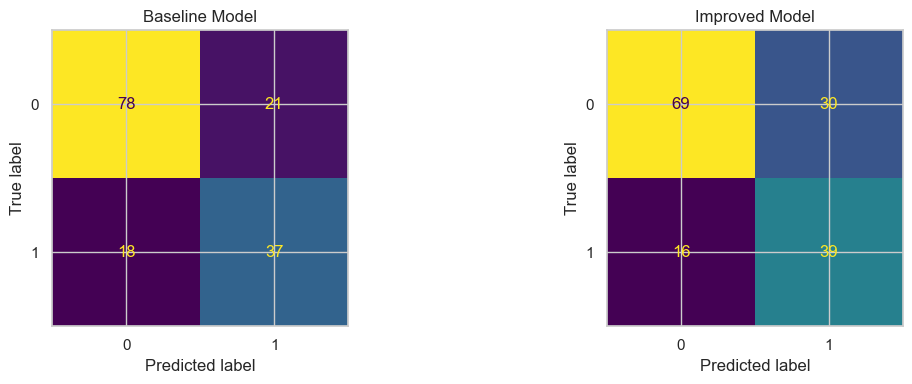

In [52]:
# Import confusion matrix visualization tool
from sklearn.metrics import ConfusionMatrixDisplay

# Create a figure with two side-by-side subplots for model comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Display confusion matrix for the baseline model (left subplot)
# Confusion matrix shows true positives, true negatives, false positives, and false negatives
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=axes[0], colorbar=False
)
axes[0].set_title("Baseline Model")

# Display confusion matrix for the improved balanced model (right subplot)
# This allows visual comparison of how class balancing affected predictions
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_bal, ax=axes[1], colorbar=False
)
axes[1].set_title("Improved Model")

plt.tight_layout()
plt.show()

Confusion matrices reveal how each model distributes errors.
The improved model predicts more positive (diabetic) cases, reducing false negatives
but increasing false positives, which explains the drop in accuracy.

### ROC curves

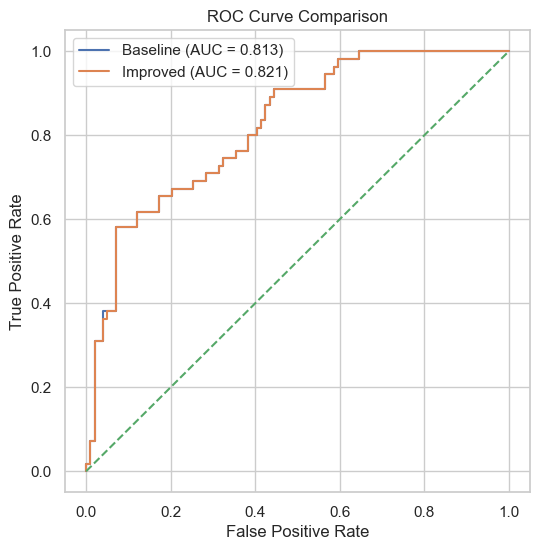

In [53]:
# Compute ROC curve points
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba)
fpr_imp, tpr_imp, _ = roc_curve(y_test, y_proba_bal)

plt.figure(figsize=(6, 6))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC = {baseline_auc:.3f})")
plt.plot(fpr_imp, tpr_imp, label=f"Improved (AUC = {improved_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

Plotting both ROC curves on the same axes allows direct comparison.
The improved model consistently achieves a higher true positive rate
for the same false positive rate, reflected in its higher ROC AUC.

### Model Comparison Summary

The baseline model performs better with respect to accuracy, primarily due to the preference it has for the majority class. On the other hand, the improved model performs best with respect to the ROC AUC score, indicating a better ability of the model in ranking diabetic risk.

Based on the confusion matrices, the improved model reduces the level of false negatives, which is especially important for real-world applications, like healthcare, where failing to identify a positive case could be harmful.

Altogether, the better model trades off a bit of accuracy for the greater benefit of fairness, having a greater concern for sensitivity.

**A “worse” accuracy model can be a better model.**

## 10. Interpreting Coefficients After Improvement

Logistic Regression assigns a coefficient to each feature.
These coefficients represent the direction and strength of each feature’s influence
on the probability of diabetes.

- A **positive coefficient** increases the probability of diabetes
- A **negative coefficient** decreases the probability of diabetes
- Larger absolute values indicate stronger influence

Because features were standardized, coefficients are directly comparable in terms of relative importance.

In [54]:
coefficients = pd.DataFrame({
    "Feature": X.columns,                      # Feature names from the training data
    "Coefficient": balanced_model.coef_[0]     # Coefficient values from the trained model
}).sort_values(by="Coefficient", ascending=False)  # Sort by coefficient magnitude (highest to lowest)

coefficients

,Feature,Coefficient
1,Glucose,1.131178
5,BMI,0.708079
7,Age,0.442448
6,DiabetesPedigreeFunction,0.238984
0,Pregnancies,0.238333
3,SkinThickness,0.076067
4,Insulin,-0.127907
2,BloodPressure,-0.167405


### Observations

- **Glucose** remains the strongest predictor, aligning with medical knowledge
- **BMI** and **Age** also show strong positive relationships with diabetes risk
- **Pregnancies** and **Diabetes Pedigree Function** have moderate influence
- **Blood Pressure** and **Insulin** show weaker or slightly negative effects

These patterns suggest that metabolic indicators dominate diabetes prediction,
while other clinical variables provide secondary context.

### Visualizing coefficients

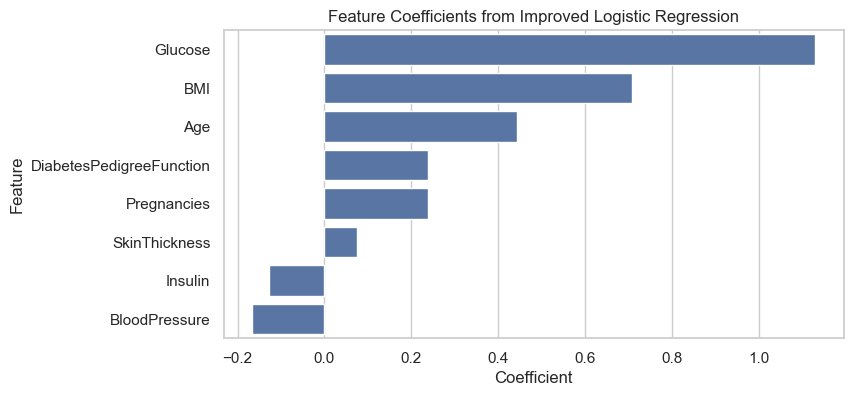

In [55]:
plt.figure(figsize=(8, 4))
sns.barplot(x="Coefficient", y="Feature", data=coefficients)
plt.title("Feature Coefficients from Improved Logistic Regression")
plt.show()

Visualizing coefficients helps compare feature importance at a glance and reinforces interpretability.

## 11. Conclusion

This project explored how a simple Logistic Regression model for diabetes prediction can be meaningfully improved without changing the underlying algorithm.

Starting with a baseline model, step-by-step enhancements were added that considered the problems with data quality and aimed at handling class imbalance and regularization. Each successive model was developed as a response to the weaknesses seen in the previous model.

Even though the accuracy dropped after class weighting, there has been an improvement in the ROC curve. ROC AUC measures the capability of the classifier model to rank instances correctly based on their diabetic risks. The confusion matrix analysis showed that the number of false negatives decreased, which was an important aspect in the medical field.

Besides the evaluation measures, the interpretability that came with the logistic regression model further allowed the consideration of the coefficients or values of the input features. The major predictors of the model, including glucose levels, body mass index, and age, stuck out as being prominent, as expected.

In essence, the results prove that with intentional preprocessing, evaluation, and interpretation, the quality of models can be greatly improved without necessarily raising the complexity of the algorithm.